Classification of DeltaAdapt Success
---
In this notebook, DeltaAdapt is classified with several modles with idnetified features. The top-performing models are listed and the interpretable models are further visualized.

** DeltaAdapt **

DeltAdapt indicate the amount that subjects changed the way the walk during training. A non-zero DeltaAdapt means that subjects were able to change the way they walked during training, whereas DeltAdapt values close to zero indicate minimal changes in gait during training. Although DeltaAdapt is continuous, here we are classifying those whose gait training was successful (i.e., gait changed due to training) versus those whose gait training was not successful (i.e., no change in gait due to training).

Import Data
---

In [1]:
import pandas as pd # Loadind Data
import matplotlib.pyplot as plt  # To visualize

df = pd.read_csv("CleanDataBase.csv")
df.head()

,Lab,ID,GroupNum,Height,Weight,Age,Male,RightLeg_Dom,RightLeg_Fast,AdaptationDurationMins,...,Stroke,TextSpeedRatio,EventDetection,DomFast,BMI,Young,TMSteadyGood,TMAfterGood,DeltaAda,DeltaAdaGood
0,SML,B001,1.0,160.0,60.9,20.0,0,1,1,NaN,...,0,2.0,NaN,1,23.789062,1,1,1,0.291812,1
1,SML,B003,1.0,174.0,68.0,20.0,0,1,1,NaN,...,0,2.0,NaN,1,22.460034,1,1,1,0.220894,1
2,SML,B004,1.0,159.0,59.2,20.0,1,1,1,NaN,...,0,2.0,NaN,1,23.416795,1,0,1,0.198431,1
3,SML,BC001,1.0,160.0,60.9,20.0,0,1,1,NaN,...,0,2.0,NaN,1,23.789062,1,1,1,0.220999,1
4,SML,BC004,1.0,165.0,65.0,20.0,1,1,1,NaN,...,0,2.0,NaN,1,23.875115,1,0,1,0.355004,1


In [2]:
# set random seed to increase repeatability
import numpy as np
RSEED=37
np.random.seed(RSEED)

DeltaAdapt Features and Targets
---


Single Features:
- AdaptationDuration

Two-Way Feature Interactions:
- ('MidBase', 'C(Stroke)[T.1]'): 0.3226168736336552,
- ('MidBase', 'C(Young)[T.1]'): 0.3978786356371071,

Three-Way Feature Interactions:
- None

In [3]:
from patsy import dmatrices

Y, X = dmatrices('DeltaAdaGood ~ AdaptationDuration +\
    SpeedDifference*MidSpeed', df, return_type="dataframe")

df_Interactions = pd.concat([X,Y], axis=1)

feature_cols = ['AdaptationDuration','SpeedDifference:MidSpeed']

target_cols = ["DeltaAdaGood"]

Split data into training and testing sets
---

In [4]:
Features = df_Interactions[feature_cols]
Target = df_Interactions[target_cols]

In [5]:
import numpy as np
np.random.seed(37)

# Split data into training and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Features,Target,test_size = 0.2)

y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

Up-Sampling
---
My DeltaAdaptGood target is reasonably well dispersed between 'good' and 'bad' adapters.

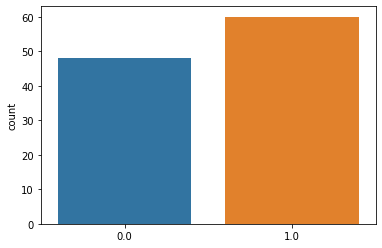

In [6]:
import seaborn as sns # Also to visualize
sns.countplot(x = y_test, data = df)
plt.show()

In [7]:
# From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = feature_cols)

In [8]:
X_train = os_data_X
y_train = os_data_y

Mass Modeling
---

In [9]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
AdaBoostClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

clfs = {'DT':   DecisionTreeClassifier(max_depth = 4),
        'RFC3':  RandomForestClassifier(max_depth = 3),
        'RFC4':  RandomForestClassifier(max_depth = 4),
        'RFC5':  RandomForestClassifier(max_depth = 5),
        'ET':   ExtraTreesClassifier(max_depth = 4),#n_estimators = 10, n_jobs = -1, criterion = 'entropy'
        'LR':   LogisticRegression(max_iter = 9000),
        'SGD':  SGDClassifier(loss = 'log'),
        'GB':   GradientBoostingClassifier(learning_rate = 0.05, subsample = 0.5, max_depth = 4, n_estimators = 10),
        'NB':   GaussianNB(),
        'KNN':  KNeighborsClassifier(1),
        'SVC1': SVC(kernel = "linear", C = 0.025),
        'SVC2': SVC(gamma = 2, C = 1),
        'GPC':  GaussianProcessClassifier(1.0 * RBF(1.0)),
        'MLP':  MLPClassifier(alpha = 1, max_iter = 1000),
        'ABC':  AdaBoostClassifier(),
        'QDA':  QuadraticDiscriminantAnalysis()}

In [10]:
sel_clfs = [ 'DT', 'ET', 'RFC3', 'LR', 'GB', 'NB', 'KNN', 'GPC',  'MLP', 'ABC']

Initialize plotting functions:

In [11]:
calc_threshold = lambda x,y: 0 if x < y else 1 

In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt  # To visualize

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

In [13]:
from sklearn.metrics import accuracy_score

def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])

        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
        
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('% Predicted > Each Thresholds')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf() 

Gini Coefficient: https://medium.com/@limavallantin/metrics-to-measure-machine-learning-model-performance-e8c963665476

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Recall Baseline: 1.0 Test: 0.95
Precision Baseline: 0.56 Test: 0.89
Accuracy Baseline: 0.5 Test: 0.91
Roc Baseline: 0.5 Test: 0.95
Gini coefficient Baseline: 0 Test: 0.9
Confusion matrix, without normalization


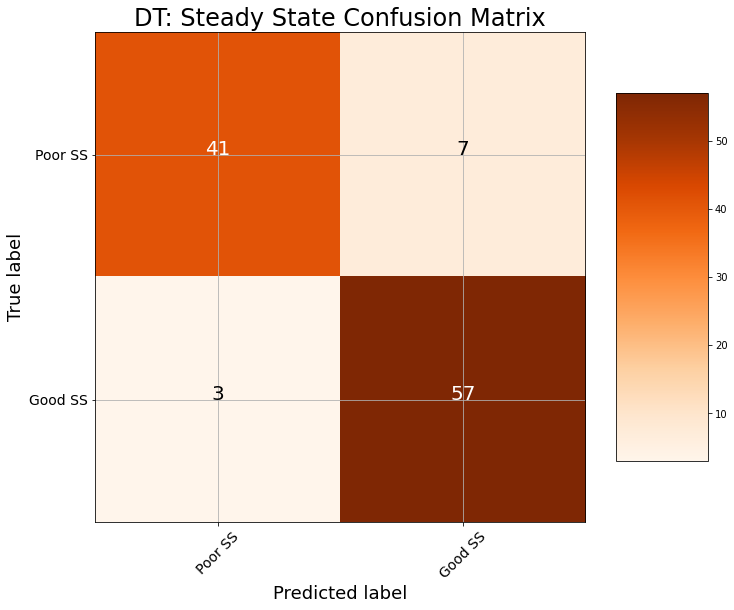

0.0


<Figure size 432x288 with 0 Axes>

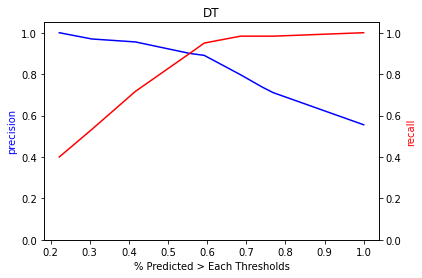

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=4, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Recall Baseline: 1.0 Test: 0.87
Precision Baseline: 0.56 Test: 0.72
Accuracy Baseline: 0.5 Test: 0.74
Roc Baseline: 0.5 Test: 0.89
Gini coefficient Baseline: 0 Test: 0.78
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

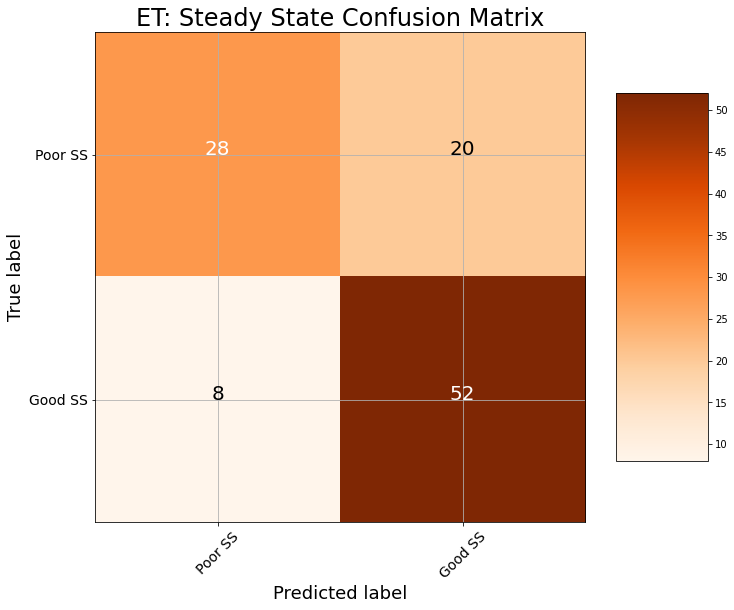

0.16797821495704277


<Figure size 432x288 with 0 Axes>

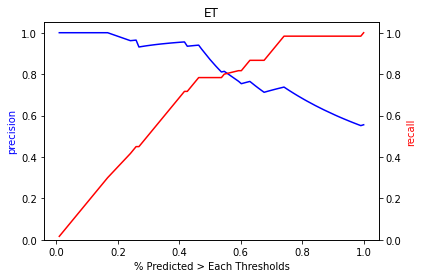

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall Baseline: 1.0 Test: 0.93
Precision Baseline: 0.56 Test: 0.8
Accuracy Baseline: 0.5 Test: 0.83
Roc Baseline: 0.5 Test: 0.9
Gini coefficient Baseline: 0 Test: 0.79
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

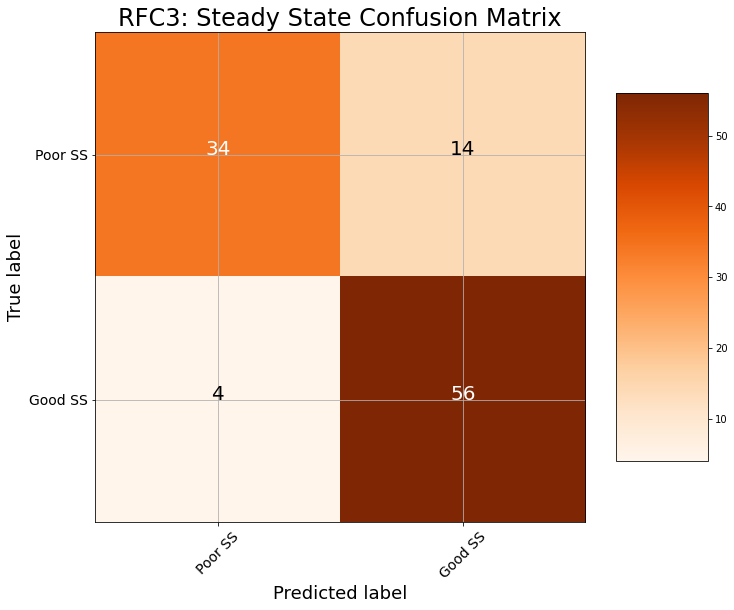

0.022222089979025274


<Figure size 432x288 with 0 Axes>

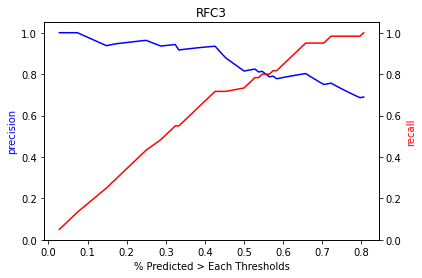

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recall Baseline: 1.0 Test: 0.48
Precision Baseline: 0.56 Test: 0.81
Accuracy Baseline: 0.5 Test: 0.65
Roc Baseline: 0.5 Test: 0.76
Gini coefficient Baseline: 0 Test: 0.53
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

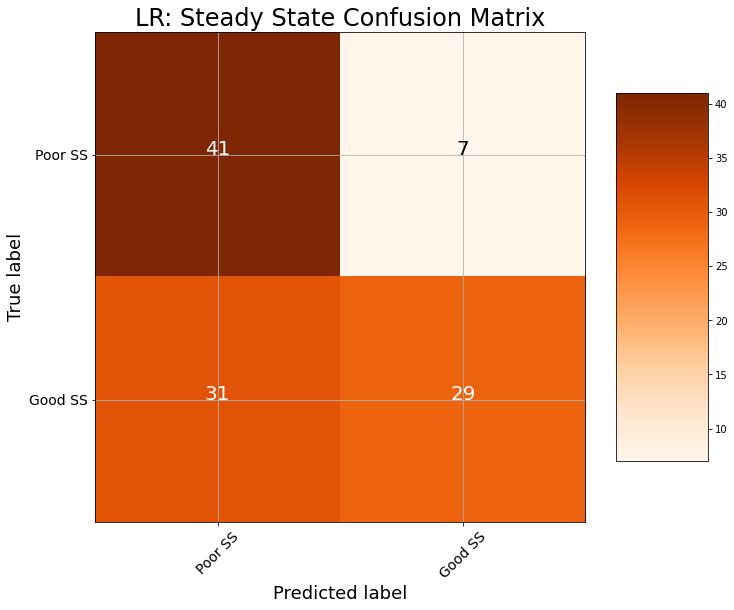

0.33862836756968423


<Figure size 432x288 with 0 Axes>

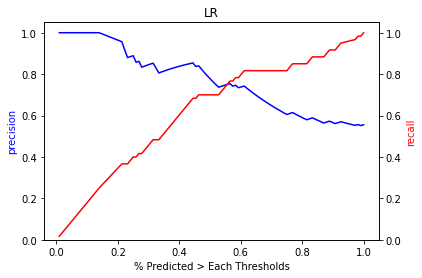

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Recall Baseline: 1.0 Test: 0.93
Precision Baseline: 0.56 Test: 0.85
Accuracy Baseline: 0.5 Test: 0.87
Roc Baseline: 0.5 Test: 0.95
Gini coefficient Baseline: 0 Test: 0.89
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

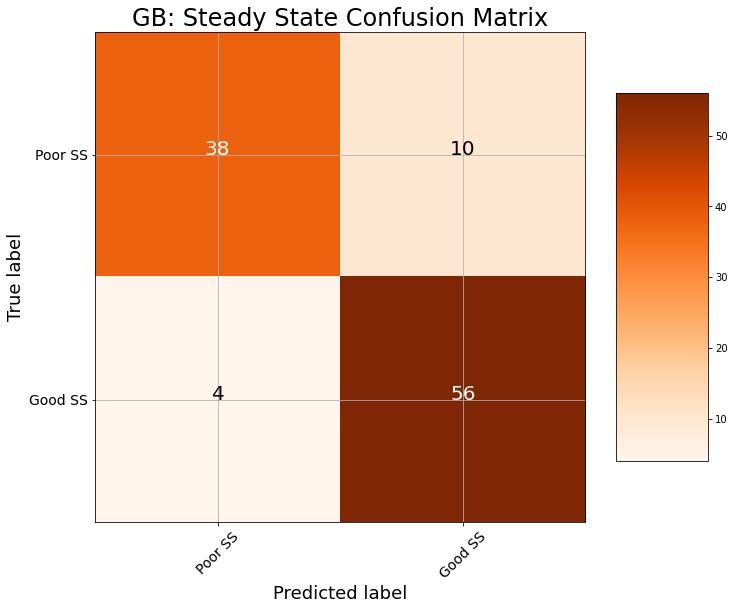

0.30068033035622066


<Figure size 432x288 with 0 Axes>

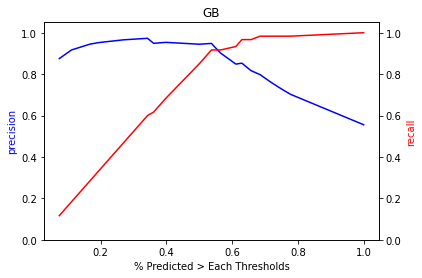

GaussianNB(priors=None, var_smoothing=1e-09)
Recall Baseline: 1.0 Test: 0.8
Precision Baseline: 0.56 Test: 0.74
Accuracy Baseline: 0.5 Test: 0.73
Roc Baseline: 0.5 Test: 0.76
Gini coefficient Baseline: 0 Test: 0.52
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

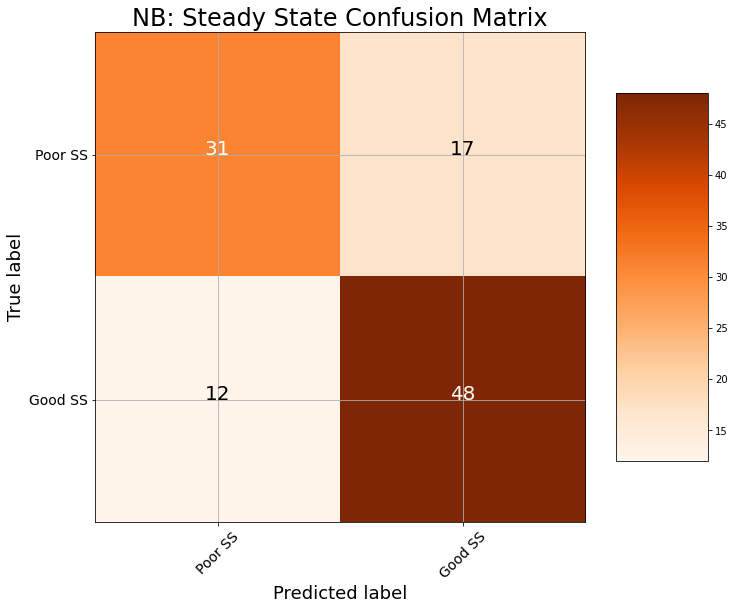

0.005753629714708617


<Figure size 432x288 with 0 Axes>

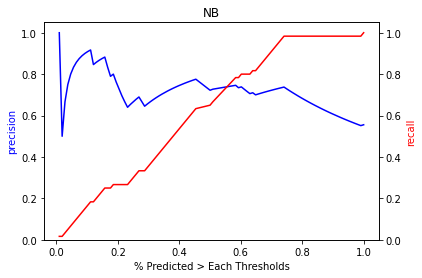

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
Recall Baseline: 1.0 Test: 0.85
Precision Baseline: 0.56 Test: 0.88
Accuracy Baseline: 0.5 Test: 0.85
Roc Baseline: 0.5 Test: 0.85
Gini coefficient Baseline: 0 Test: 0.7
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

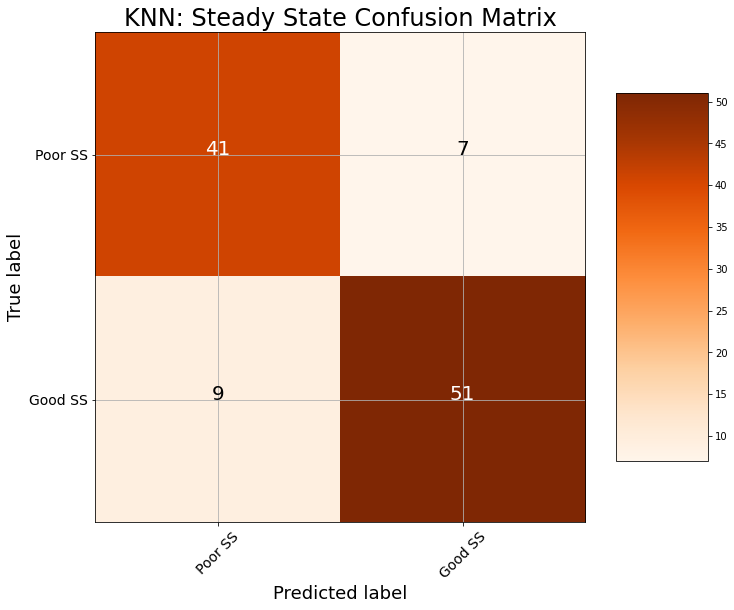

0.0


<Figure size 432x288 with 0 Axes>

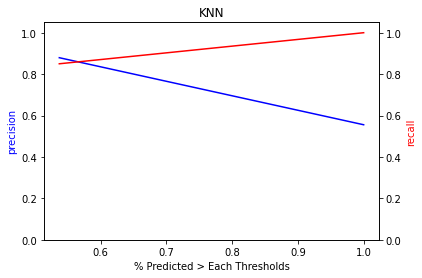

GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)
Recall Baseline: 1.0 Test: 0.8
Precision Baseline: 0.56 Test: 0.89
Accuracy Baseline: 0.5 Test: 0.83
Roc Baseline: 0.5 Test: 0.92
Gini coefficient Baseline: 0 Test: 0.84
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

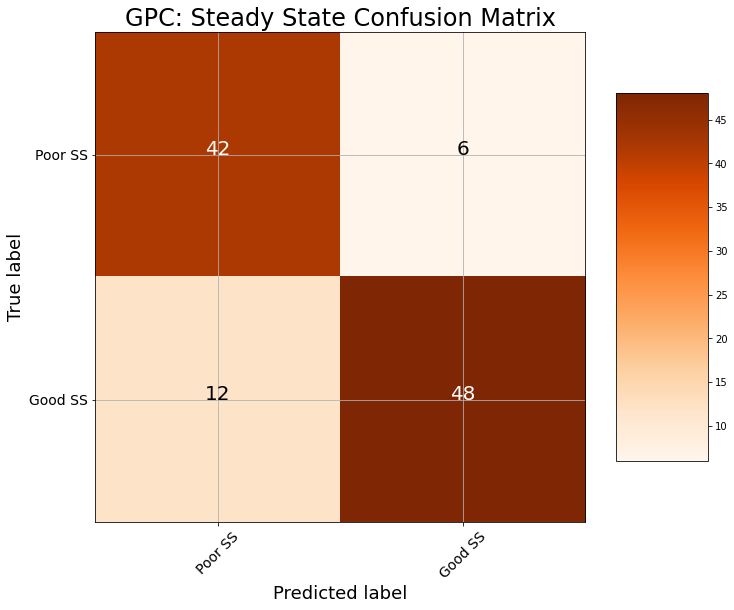

0.06332882590265854


<Figure size 432x288 with 0 Axes>

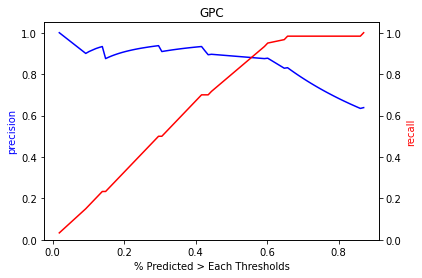

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Recall Baseline: 1.0 Test: 0.67
Precision Baseline: 0.56 Test: 0.54
Accuracy Baseline: 0.5 Test: 0.5
Roc Baseline: 0.5 Test: 0.47
Gini coefficient Baseline: 0 Test: -0.06
Confusion matrix, without normalization


/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

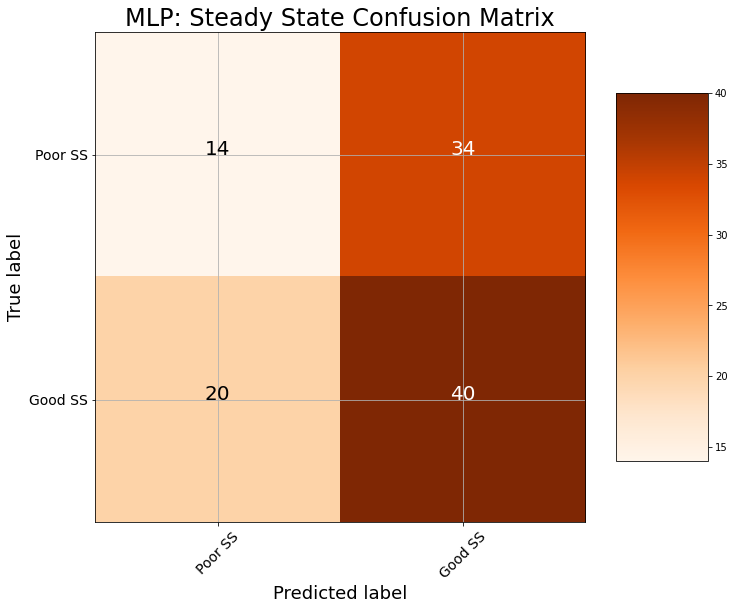

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Recall Baseline: 1.0 Test: 0.9
Precision Baseline: 0.56 Test: 0.82
Accuracy Baseline: 0.5 Test: 0.83
Roc Baseline: 0.5 Test: 0.91
Gini coefficient Baseline: 0 Test: 0.82
Confusion matrix, without normalization


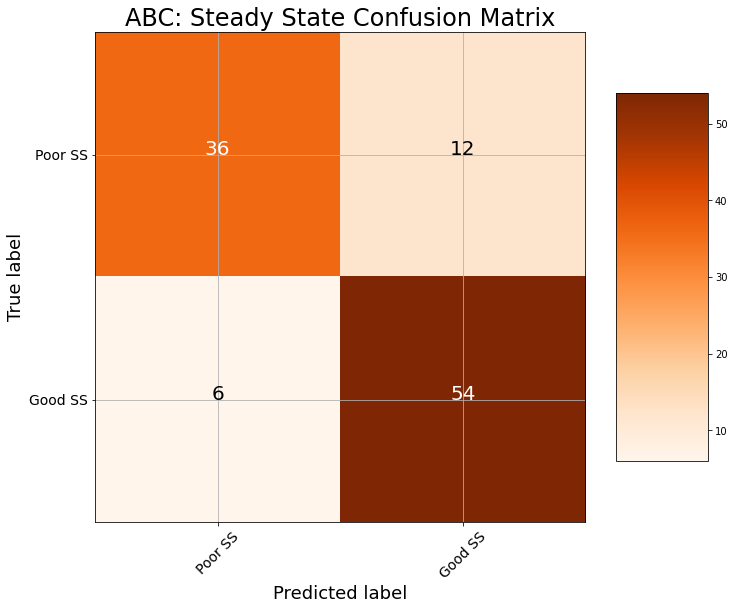

0.46402671035879833


<Figure size 432x288 with 0 Axes>

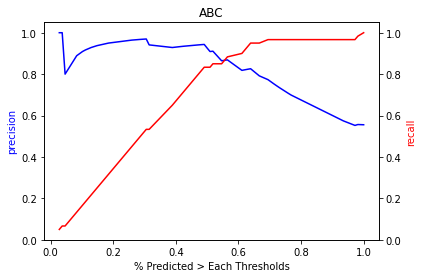

In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve
import math

for clfNM in sel_clfs:
    clf = clfs[clfNM]
    print(clf)
    clf.fit( X_train, y_train )
    predicted = clf.predict(X_test)
    expected = np.array(y_test)
    
    try:
        y_score = clf.predict_proba(X_test)[:,1]  
        predicted_prob = np.array(y_score)
    except AttributeError:
        y_score[1] = 10000
    
    # Evaluation: Recall, Precision, and Accuracy
    baseline = {}
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    baseline['accuracy'] = 0.5
    baseline['Gini Coefficient'] = 0
    
    results = {}
    results['recall'] = recall_score(y_test, predicted)
    results['precision'] = precision_score(y_test, predicted)
    results['accuracy'] = accuracy_score(y_test, predicted)
    try:
        results['roc'] = roc_auc_score(y_test, predicted_prob)#NEW
        results['Gini Coefficient'] = (2*roc_auc_score(y_test, predicted_prob))-1#NEW
    except NameError:
        results['roc'] = {}
        results['Gini Coefficient'] = {}
    
    for metric in ['recall', 'precision', 'accuracy', 'roc', 'Gini Coefficient']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)}')
    
    # Evaluation: Visualize Confusion Matrix
    plot_confusion_matrix(confusion_matrix(expected, predicted),
                        classes = ['Poor SS', 'Good SS'],
                      title = clfNM + ': Steady State Confusion Matrix')

    # Evaluation: Precision Recall Curves
    if (np.isnan(y_score[1]) != True) & (y_score[1] < 1 ):
        print(y_score[1])
        plot_precision_recall_n(expected, predicted_prob, clfNM)

** Best Models**

RandomForestClassifier:
- Recall Baseline: 1.0 Test: 0.93
- Precision Baseline: 0.56 Test: 0.8
- Accuracy Baseline: 0.5 Test: 0.83
- Roc Baseline: 0.5 Test: 0.9
- Gini coefficient Baseline: 0 Test: 0.79

GradientBoostingClassifier:
- Recall Baseline: 1.0 Test: 0.93
- Precision Baseline: 0.56 Test: 0.85
- Accuracy Baseline: 0.5 Test: 0.87
- Roc Baseline: 0.5 Test: 0.95
- Gini coefficient Baseline: 0 Test: 0.89

GaussianProcessClassifier
- Recall Baseline: 1.0 Test: 0.8
- Precision Baseline: 0.56 Test: 0.89
- Accuracy Baseline: 0.5 Test: 0.83
- Roc Baseline: 0.5 Test: 0.92
- Gini coefficient Baseline: 0 Test: 0.84

AdaBoostClassifier:
- Recall Baseline: 1.0 Test: 0.9
- Precision Baseline: 0.56 Test: 0.82
- Accuracy Baseline: 0.5 Test: 0.83
- Roc Baseline: 0.5 Test: 0.91
- Gini coefficient Baseline: 0 Test: 0.82

In Conclusion...
---

In conclusion, the sucess of individuals to alter their gait pattern can be **classified with Recall, Precision, and Accuracy scores greater than 0.80**.  Random forests are one of the interpretable models that is able to make good classification. 

Final Random Forest
---

In [15]:
from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg

def SaveAndVisualizeForest(model, figName, FeatureNames):
    
    try:
        estimator = model.estimators_[5]
    except AttributeError:
        estimator = model

    export_graphviz(estimator, out_file = figName + '.dot', feature_names = FeatureNames,
                rounded = True, precision = 1, class_names = ['goodDeltaA', 'badDeltaA'], filled = True)

    # Use dot file to create a graph
    (graphy, ) = pydot.graph_from_dot_file(figName + '.dot')

    # Write graph to a png file
    graphy.write_png(figName + '.png'); 
    
    #Visualize for notebook
    img = mpimg.imread(figName + '.png')
    fig = plt.figure()
    fig.set_size_inches(30,10)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

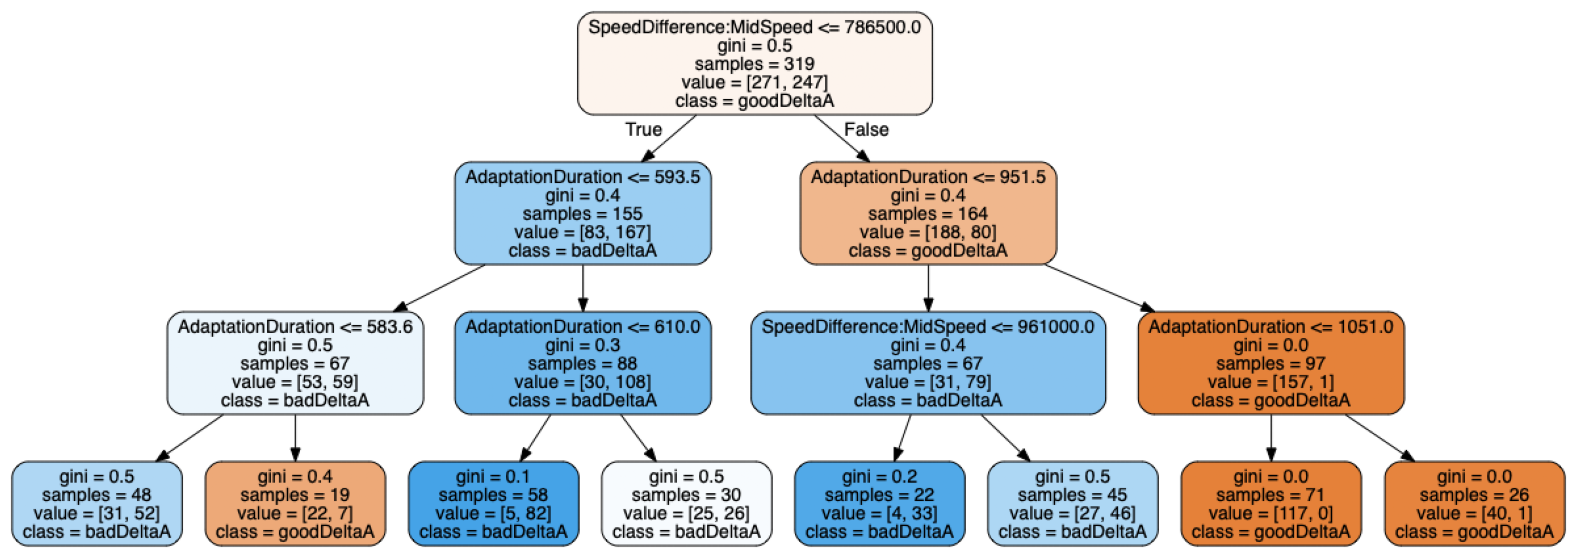

In [16]:
clf = clfs['RFC3']
clf = clf.fit( X_train, y_train )

SaveAndVisualizeForest(clf, 'DA_RF3', feature_cols)

Implications of Models
---

The random forest model generally indicates that the duration of training (AdaptationDuration) should be long, the mid training speed (MidSpeed) should be faster, and Speed Difference (SpeedDifference) should be large in order to have a high probability of chaning gait during traning. Note that the belt ratio (SpeedRatio) was not an important factor.
